In [33]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Loading Data

In [34]:
force = False
training_data = datasets.MNIST('data',train=True,download=force,transform=ToTensor())
test_data = datasets.MNIST('data',train=False,transform=ToTensor())

In [35]:
def load_gan_data(path = './data/MNIST_GENERATED.pth'):
    import numpy as np
    data = torch.load('./data/MNIST_GENERATED.pth')
    return list((X,y) for X,y in zip(data['data'],data['label']))
gan_data = load_gan_data()

In [36]:
batch_size = 100
train_dataloader = DataLoader(training_data,batch_size=batch_size)
gan_dataloader = DataLoader(gan_data,batch_size=batch_size)
test_dataloader = DataLoader(test_data,batch_size=batch_size)


def print_shape(dataloader):
    X,y = next(iter(dataloader))
    print(f"step per epoch - {len(dataloader)}")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
print_shape(train_dataloader)
print_shape(gan_dataloader)
print_shape(test_dataloader)

step per epoch - 600
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64
step per epoch - 100
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64
step per epoch - 100
Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64


# Device for Training

In [37]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Model Development

In [38]:
class Digit_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=6, stride=2),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(288, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(1),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = Digit_Classifier().to(device)
print(model)

Digit_Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 24, kernel_size=(6, 6), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(24, 32, kernel_size=(6, 6), stride=(2, 2))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=288, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


# Optimization configuration

In [39]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 10 
max_learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr = max_learning_rate,
                                          steps_per_epoch=len(gan_dataloader),
                                          epochs=epochs)
train_loss_hist = []
test_loss_hist = []
acc_hist = []

# Develop Optimization Iteration

In [40]:
def train(dataloader, model, loss_fn, optimizer,scheduler):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        losses.append(loss.item())

    return sum(losses)/len(losses)
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss,correct

def plot_loss(train_loss_hist,test_loss_hist,acc_hist):
    import matplotlib.pyplot as plt
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle(f'Epoch - {len(test_loss_hist)}')
    ax1.plot(train_loss_hist,label='train loss')
    ax1.plot(test_loss_hist,label='test loss')
    ax1.legend()
    ax2.plot(acc_hist,label='acc')
    ax2.legend()
    plt.show()

# Run the iteration

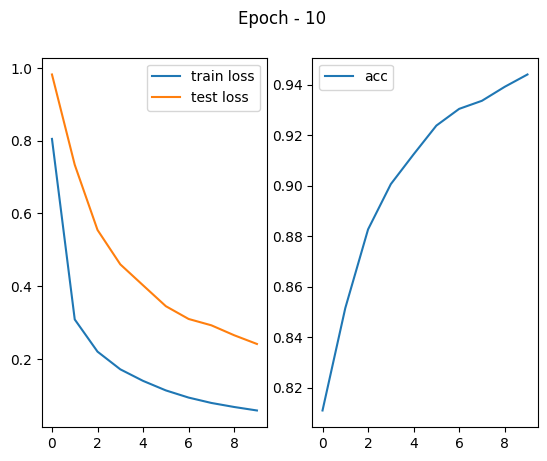

Saved PyTorch Model State to model_checkpoint/mnist_reduced_cnn_gan.pth


In [41]:
def fn():
    from IPython.display import clear_output
    for t in range(epochs):
        loss = train(test_dataloader, model, loss_fn, optimizer,scheduler)
        loss += train(gan_dataloader, model, loss_fn, optimizer,scheduler)
        loss /= 2
        
        train_loss_hist.append(loss)
        test_loss,acc = test(train_dataloader, model, loss_fn)
        test_loss_hist.append(test_loss)
        acc_hist.append(acc)
        
        clear_output()
        plot_loss(train_loss_hist,test_loss_hist,acc_hist)
        
    checkpoint_path = "model_checkpoint/mnist_reduced_cnn_gan.pth"
    torch.save(model.state_dict(),checkpoint_path )
    print(f"Saved PyTorch Model State to {checkpoint_path}")
fn()

In [12]:
model = Digit_Classifier()
checkpoint_path = "model_checkpoint/mnist_reduced_cnn.pth"
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

test(train_dataloader, model, loss_fn)

(0.17611650214996188, 0.9481)

In [42]:
model = Digit_Classifier()
checkpoint_path = "model_checkpoint/mnist_reduced_cnn_gan.pth"
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

test(train_dataloader, model, loss_fn)

(0.24087712637536848, 0.944)